# SCF optimization

Let us implement the presented Hartree--Fock SCF procedure. We will use the water molecule as an example and, as reference, we will first compute the Hartree–Fock energy using the built-in `compute` method in VeloxChem. 

## Setting up the system

In [1]:
import numpy as np
import veloxchem as vlx
import matplotlib.pyplot as plt

mol_str = """3

O    0.000000000000        0.000000000000        0.000000000000
H    0.000000000000        0.740848095288        0.582094932012
H    0.000000000000       -0.740848095288        0.582094932012
"""

molecule = vlx.Molecule.read_xyz_string(mol_str)
basis = vlx.MolecularBasis.read(molecule, "cc-pVDZ")

* Warning * Environment variable OMP_NUM_THREADS not set.
* Warning * Setting OMP_NUM_THREADS to 4.
* Info * Reading basis set from file: /home/thomas/Notebook/anaconda/envs/echem/lib/python3.10/site-packages/veloxchem/basis/CC-PVDZ
                                                                                                                          
                                              Molecular Basis (Atomic Basis)                                              
                                                                                                                          
                               Basis: CC-PVDZ                                                                             
                                                                                                                          
                               Atom Contracted GTOs           Primitive GTOs                                              
                             

In [2]:
import py3Dmol as p3d
viewer = p3d.view(width=300, height=200)
viewer.addModel(mol_str, 'xyz')
viewer.setViewStyle({"style": "outline", "width": 0.05})
viewer.setStyle({"stick":{},"sphere": {"scale":0.25}})
viewer.rotate(90,'y')
viewer.rotate(-90,'x')
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [6]:
norb = basis.get_dimensions_of_basis(molecule)
nocc = molecule.number_of_electrons() // 2
V_nuc = molecule.nuclear_repulsion_energy()

print("Number of contracted basis functions:", norb)
print("Number of doubly occupied molecular orbitals:", nocc)
print(f"Nuclear repulsion energy (in a.u.): {V_nuc : 14.12f}")

Number of contracted basis functions: 24
Number of doubly occupied molecular orbitals: 5
Nuclear repulsion energy (in a.u.):  9.343638157670


## Reference calculation

Let us first perform an reference calculation using the restricted closed-shell SCF driver in VeloxChem.

In [7]:
scf_drv = vlx.ScfRestrictedDriver()
scf_results = scf_drv.compute(molecule, basis)

                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Hartree-Fock                                         
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10                                                                   
                

In [8]:
print(f"Final HF energy: {scf_drv.get_scf_energy() : 12.8f} Hartree")

Final HF energy: -76.02698419 Hartree


## Getting integrals in AO basis

In [9]:
# overlap matrix
overlap_drv = vlx.OverlapIntegralsDriver()
S = overlap_drv.compute(molecule, basis).to_numpy()

# one-electron Hamiltonian
kinetic_drv = vlx.KineticEnergyIntegralsDriver()
T = kinetic_drv.compute(molecule, basis).to_numpy()

nucpot_drv = vlx.NuclearPotentialIntegralsDriver()
V = -nucpot_drv.compute(molecule, basis).to_numpy()

h = T + V

# two-electron Hamiltonian
eri_drv = vlx.ElectronRepulsionIntegralsDriver()
g = np.zeros((norb, norb, norb, norb))
eri_drv.compute_in_memory(molecule, basis, g)

## Orthogonalization of the AO basis

We first retrieve an *orthogonal* AO (OAO) basis by means of a non-unitary transformation matrix $\mathbf{X}$ such that

$$
| \overline{\chi^\mathrm{OAO}} \rangle = | \overline{\chi} \rangle \mathbf{X}
$$

and 

$$
\mathbf{S}^\mathrm{OAO} = \mathbf{X}^\dagger \mathbf{S X} = \mathbf{I}
$$

In the absence of linear dependencies in the AO basis, the overlap matrix is symmetric (and positive-definite) and it can first be diagonalized by a unitary transformation

$$
\mathbf{U}^{\dagger} \mathbf{S U} = \boldsymbol{\sigma}
$$

where $\boldsymbol{\sigma}$ is a diagonal matrix collecting the eigenvalues. It is then straightforward to construct explicit forms of $\mathbf{X}$. There exist two common choices:

| symmetric form  | canonical form |
| :-------------: | :------------: |
| $\mathbf{X} = \mathbf{U} \boldsymbol{\sigma}^{-\frac{1}{2}} \mathbf{U}^\dagger$ | $\mathbf{X} = \mathbf{U} \boldsymbol{\sigma}^{-\frac{1}{2}}$ | 

We can readily verify that both expressions satisfy $\mathbf{X}^\dagger \mathbf{S X} = \mathbf{I}$.

The expression for the associated transformation of MO coefficients is determined from the relation

$$
| \overline{\phi} \rangle = | \overline{\chi} \rangle \mathbf{C} =
| \overline{\chi^\mathrm{OAO}} \rangle \mathbf{X}^{-1} \mathbf{C}
$$

We identify

$$
\mathbf{C}^\mathrm{OAO} = \mathbf{X}^{-1} \mathbf{C}
$$

or

$$
\mathbf{C} = \mathbf{X C}^\mathrm{OAO}
$$

In [10]:
# symmetric transformation
sigma, U = np.linalg.eigh(S)
X = np.einsum("ik,k,jk->ij", U, 1 / np.sqrt(sigma), U)

## Solving the Hartree–Fock equation
For a given Fock matrix, we solve the Hartree–Fock equation by the following steps:

1. transform the Fock matrix to the OAO basis
2. diagonalize the Fock matrix
3. transform the MO coefficients back to AO basis

In [11]:
def get_MO_coeff(F):

    F_OAO = np.einsum("ki,kl,lj->ij", X, F, X)
    epsilon, C_OAO = np.linalg.eigh(F_OAO)
    C = np.einsum("ik,kj->ij", X, C_OAO)

    return C

## SCF iterations
We form an initial guess for the density based on the core Hamiltonian and thereafter enter the SCF iterations. As a measure of convergence, we adopt the norm of the following matrix in AO basis

$$
\mathbf{e} = 
\mathbf{F D S} -
\mathbf{S D F}
$$

It is convenient to scatter the elements of this matrix into the format of a vector and which we refer to as the *error vector*. During the course of the SCF iterations, we form a sequence of error vectors, $\mathbf{e}_i$.

The choice of convergence metric may at first appear unintuitive but becomes less so in the MO basis

$$
\mathbf{e}^\mathrm{MO} = 
\mathbf{C}^\dagger \mathbf{e} \, \mathbf{C} =
\begin{bmatrix}
0 & -F_\mathrm{ov} \\
F_\mathrm{vo} & 0 \\
\end{bmatrix}
$$

where it is seen to correspond to vanishing occupied—virtual blocks in the Fock matrix.

In [12]:
max_iter = 50
conv_thresh = 1e-6

E_RH = []

# initial guess from core Hamiltonian
C = get_MO_coeff(h)

print("iter      SCF energy    Error norm")

for iter in range(max_iter):

    D = np.einsum("ik,jk->ij", C[:, :nocc], C[:, :nocc])

    J = np.einsum("ijkl,kl->ij", g, D)
    K = np.einsum("ilkj,kl->ij", g, D)
    F = h + 2 * J - K

    E = np.einsum("ij,ij->", h + F, D) + V_nuc

    # compute convergence metric
    e_mat = np.linalg.multi_dot([F, D, S]) - np.linalg.multi_dot([S, D, F])
    e_vec = e_mat.reshape(-1)
    error = np.linalg.norm(e_vec)

    print(f"{iter:>2d}  {E:16.8f}  {error:10.2e}")
    E_RH.append(error)

    if error < conv_thresh:
        print("SCF iterations converged!")
        break

    C = get_MO_coeff(F)

iter      SCF energy    Error norm
 0      -68.84975229    3.09e+00
 1      -69.95937641    2.88e+00
 2      -73.34743276    2.83e+00
 3      -73.46688910    2.23e+00
 4      -74.74058933    2.18e+00
 5      -75.55859127    1.41e+00
 6      -75.86908635    8.26e-01
 7      -75.97444165    4.82e-01
 8      -76.00992921    2.74e-01
 9      -76.02143957    1.57e-01
10      -76.02519173    8.89e-02
11      -76.02640379    5.06e-02
12      -76.02679653    2.88e-02
13      -76.02692347    1.64e-02
14      -76.02696455    9.31e-03
15      -76.02697784    5.30e-03
16      -76.02698213    3.01e-03
17      -76.02698352    1.71e-03
18      -76.02698397    9.74e-04
19      -76.02698412    5.54e-04
20      -76.02698416    3.15e-04
21      -76.02698418    1.79e-04
22      -76.02698418    1.02e-04
23      -76.02698419    5.80e-05
24      -76.02698419    3.30e-05
25      -76.02698419    1.88e-05
26      -76.02698419    1.07e-05
27      -76.02698419    6.07e-06
28      -76.02698419    3.45e-06
29      

# Convergence acceleration

## Direct inversion iterative subspace

The Rothaan–Hall scheme suffer from poor numerical convergence and in practice some version of convergence acceleration is adopted. In the method of direct inversion of the iterative subspace (DIIS) {cite}`Pulay1980, Pulay1982, Sellers1993` information is used from not only the present but also previous iterations to form an *averaged* effective one-electron Hamiltonian, or Fock matrix, according to

$$
\mathbf{F}_n^\mathrm{DIIS} = \sum_{i=1}^n w_i \mathbf{F}_i
$$

where $\mathbf{F}_i$ is the Fock matrix generated in SCF iteration $i$, $n$ is present iteration, and the weights, $w_i$, are to be determined. To guarantee that the one-electron Hamiltonian is preserved in the effective Fock operator,  we impose the condition

$$
\sum_{i=1}^n w_i = 1
$$

Under the assumption of a strict linearity between Fock matrices and error vectors, the error vector of the averaged Fock matrix would equal

$$
\mathbf{e}_n^\mathrm{DIIS} = \sum_{i=1}^n w_i \mathbf{e}_i
$$

As the molecular orbitals change from one iteration to the next, this is not strictly the case but it is a good approximation. We can then determine the weights by minimizing the squared norm of this error vector under the imposed constraint. The squared norm becomes equal to

$$
\| \mathbf{e}_n^\mathrm{DIIS} \|^2 =
\sum_{i,j=1}^n w_i B_{ij} w_j ; \quad
B_{ij} = \langle \mathbf{e}_i | \mathbf{e}_j \rangle
$$

and the constrained minimization is achieved by introducing a Lagrangian

$$
L =
\| \mathbf{e}_n^\mathrm{DIIS} \|^2 - 2\lambda
\Big(
\sum_{i=1}^n w_i - 1
\Big)
$$

where the factor of $-2$ multiplying the Lagrange multiplier $\lambda$ is a mere convention as to arrive at an explicit matrix equation of the form

$$
\begin{pmatrix}
B_{11} & \cdots & B_{1n} & -1 \\
\vdots & \ddots & \vdots & \vdots \\
B_{n1} & \cdots & B_{nn} & -1 \\
-1 & \cdots & -1 & 0
\end{pmatrix}
\begin{pmatrix}
w_1 \\ \vdots \\ w_n \\ \lambda
\end{pmatrix}
=
\begin{pmatrix}
0 \\ \vdots \\ 0 \\ -1
\end{pmatrix}
$$

We solve this equation for the weights, $w_i$, and then determine the averaged Fock matrix, $\mathbf{F}_n^\mathrm{DIIS}$.

In [17]:
def c1diis(F_mats, e_vecs):

    n = len(e_vecs)

    # build DIIS matrix
    B = -np.ones((n + 1, n + 1))
    B[n, n] = 0

    for i in range(n):
        for j in range(n):
            B[i, j] = np.dot(e_vecs[i], e_vecs[j])

    b = np.zeros(n + 1)
    b[n] = -1

    w = np.matmul(np.linalg.inv(B), b)

    F_diis = np.zeros((norb, norb))
    for i in range(n):
        F_diis += w[i] * F_mats[i]

    return F_diis

## SCF iterations
In principle, the only needed modification in the SCF module to implement the DIIS scheme is to replace the original Fock matrix with the weighted averaged counterpart before the determination of the new MO coefficients. But it is also required to save Fock matrices and error vectors from previous SCF iterations. In practice, this extra storage requirement does not severely hamper applications, and in particular so as an optimum stabilitity in the DIIS scheme is experienced with the use of information from a limited number (about 10) of the previous iterations.

In [18]:
e_vecs = []
F_mats = []
E_DIIS = []

# initial guess from core Hamiltonian
C = get_MO_coeff(h)

print("iter      SCF energy    Error norm")

for iter in range(max_iter):

    D = np.einsum("ik,jk->ij", C[:, :nocc], C[:, :nocc])

    J = np.einsum("ijkl,kl->ij", g, D)
    K = np.einsum("ilkj,kl->ij", g, D)
    F = h + 2 * J - K
    F_mats.append(F)

    E = np.einsum("ij,ij->", h + F, D) + V_nuc

    # compute convergence metric
    e_mat = np.linalg.multi_dot([F, D, S]) - np.linalg.multi_dot([S, D, F])
    e_vecs.append(e_mat.reshape(-1))
    error = np.linalg.norm(e_vecs[-1])

    print(f"{iter:>2d}  {E:16.8f}  {error:10.2e}")
    E_DIIS.append(error)

    if error < conv_thresh:
        print("SCF iterations converged!")
        break

    F = c1diis(F_mats, e_vecs)
    C = get_MO_coeff(F)

iter      SCF energy    Error norm
 0      -68.84975229    3.09e+00
 1      -69.95937641    2.88e+00
 2      -75.88501761    8.37e-01
 3      -75.97016719    5.18e-01
 4      -76.01483442    2.34e-01
 5      -76.02676704    3.29e-02
 6      -76.02698021    3.32e-03
 7      -76.02698392    8.01e-04
 8      -76.02698418    2.04e-04
 9      -76.02698419    6.97e-05
10      -76.02698419    2.06e-06
11      -76.02698419    5.43e-07
SCF iterations converged!


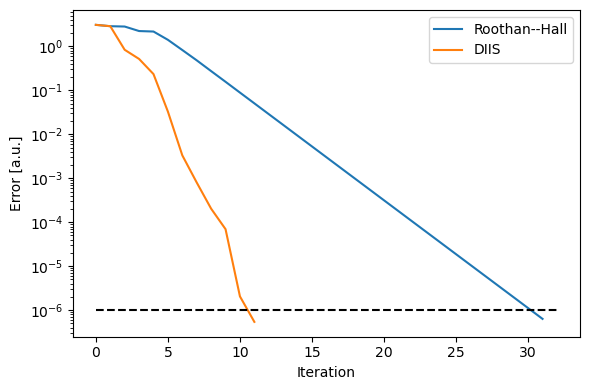

In [29]:
plt.figure(figsize=(6,4))

plt.plot(E_RH)
plt.plot(E_DIIS)
plt.plot([0,len(E_RH)],[1e-6,1e-6],'k--')
plt.legend(('Roothan--Hall','DIIS'))

plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'Error norm')
plt.tight_layout()
plt.show()